# Data Preparation

### This notebook is a rewrite of the previous notebook with the objective of making the data preparation steps easier and modular.

In [94]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
from sklearn.cross_validation import train_test_split
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import os

import re


### 1. Generating the pressure and velocity fields
The following extracts the pressure and velocity fields from the original OpenFOAM files and creates the files *pressure.txt* and *velocity.txt* that are ready to be imported by the pandas library.

In [121]:
# for folders in ['machineRANS/0.1','machineRANS/0.2','machineLES/0.1','machineLES/0.2']:
for folders in ['machineRANS/0.15','machineRANS/0.05','machineLES/0.15','machineLES/0.05']:
    folder = os.getcwd()+'/OpenFOAMfiles/turbulent/'+folders
    for field in ['p','U']:
        file   = folder+'/'+field
        with open(file,'r') as f:
            text = f.readlines()
            text = text[22:43772]

        if field == 'p':
            file   = folder+'/pressure.txt'
            with open(file,'w') as f:
                f.write('pressure\n')
                f.write(''.join(text))
        else:
            file   = folder+'/velocity.txt'
            with open(file,'w') as f:
                f.write('vx vy vz\n')
                vel = ''.join(text)
                vel = re.sub('[()]','', vel)
                f.write(vel)

Generate the turbulent properties for the RANS simulation

In [123]:
folder = os.getcwd()+'/OpenFOAMfiles/turbulent/machineRANS/0.05'
for field in ['nut','k','epsilon']:
    file   = folder+'/'+field
    with open(file,'r') as f:
        text = f.readlines()
        text = text[22:43772]
    file   = folder+'/'+field+'.txt'
    with open(file,'w') as f:
        f.write(field+'\n')
        f.write(''.join(text))


### 2. Function Definition
The function to import the data is written here.

In [3]:
def undonormalize(xn,xmax,xmin):
    """
    Transform data back to the original scale
    : xn: Data that was normalized
    : xmax: Maximum value before data normalization
    : xmin: Minimum value before data normalization
    : return: Numpy array of data with original scale
    """
    x = xn*(xmax-xmin)+xmin
    return x

def ImportData(folder):
    file_list = []
    file_list.append(pd.read_table('./Mesh/meshcoord.txt',sep="\s+"))
    file_list.append(pd.read_table(folder+'/pressure.txt'))
    file_list.append(pd.read_csv(folder+'/velocity.txt',sep="\s+"))
    df = pd.DataFrame()
    df = pd.concat(file_list,axis=1)
    df = df.drop(['vz','v','ccz'],axis=1)
    
    vx,ccx,ccy = np.histogram2d(df.ccx,df.ccy,weights=df.vx,bins=(225,200))
    vy,ccx,ccy = np.histogram2d(df.ccx,df.ccy,weights=df.vy,bins=(225,200))
    p,ccx,ccy = np.histogram2d(df.ccx,df.ccy,weights=df.pressure,bins=(225,200))
    _,ccx,ccy = np.histogram2d(df.ccx,df.ccy,weights=df.vx,bins=(224,199))


    o = np.zeros((225,200))
    xg, yg = np.meshgrid(np.arange(100,125,1),np.arange(0,50,1))
    for i in np.arange(100,125,1):
        for j in np.arange(0,50,1):
            o[i,j] = 1


    VY = np.vstack((np.zeros(200),vy,np.zeros(200)))
    VY = np.hstack((np.zeros((227,1)),VY,np.zeros((227,1))))
    VX = np.vstack((np.zeros(200),vx,np.zeros(200)))
    VX = np.hstack((np.zeros((227,1)),VX,np.zeros((227,1))))
    P = np.vstack((np.zeros(200),p,np.zeros(200)))
    P = np.hstack((np.zeros((227,1)),P,np.zeros((227,1))))
    O = np.vstack((np.ones(200)+5,o,np.ones(200)+2))
    O = np.hstack((np.ones((227,1)),O,np.ones((227,1))))

    VX = VX.T[::-1]
    VY = VY.T[::-1]
    P  = P.T[::-1]
    O  = O.T[::-1]
    
    plist = []
    for i in np.arange(1,201,1):
        for j in np.arange(1,226,1):
            plist.append({'pin':P[i,j],'pright':P[i,j-1],'pleft':P[i,j+1],
                           'pup':P[i-1,j],'pdown':P[i+1,j],
                          'vxin':VX[i,j],'vright':VX[i,j-1],'vleft':VX[i,j+1],
                          'vup':VY[i-1,j],'vdown':VY[i+1,j],'vyin':VY[i,j],
                          'oin':O[i,j],'oright':O[i,j-1],'oleft':O[i,j+1],
                          'oup':O[i-1,j],'odown':O[i+1,j],
                          'ccx':ccx[j-1],'ccy':ccy[-i]
                         })
            
    data= pd.DataFrame(plist)
    return data


### 3. File importation

First, import a sample file and check the variables distribution.

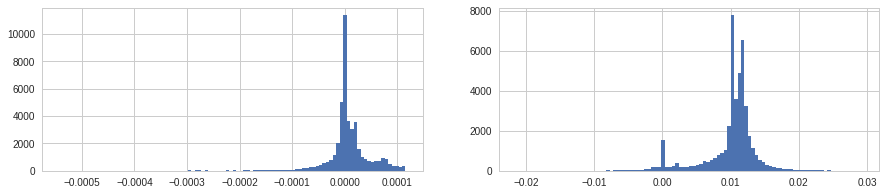

In [98]:
folder = os.getcwd()+'/OpenFOAMfiles/98'
data = ImportData(folder)
plt.figure(figsize=(15,3))
plt.subplot(121)
data.pin.hist(bins=100)
plt.subplot(122)
data.vxin.hist(bins=100)

Now, import the files to be used in the training and testing.

In [107]:
folder = os.getcwd()+'/OpenFOAMfiles/90'
data1 = ImportData(folder)
folder = os.getcwd()+'/OpenFOAMfiles/95'
data2 = ImportData(folder)
folder = os.getcwd()+'/OpenFOAMfiles/100'
data3 = ImportData(folder)

In [120]:
data1.head()

,ccx,ccy,odown,oin,oleft,oright,oup,pdown,pin,pleft,pright,pup,vdown,vleft,vright,vup,vxin,vyin
0,0.01,3.99,0.0,0.0,0.0,6.0,1.0,0.000031,0.000044,0.000035,0.000000,0.0,-0.000389,0.009015,0.000000,0.0,0.009596,-0.000328
1,0.03,3.99,0.0,0.0,0.0,0.0,1.0,0.000029,0.000035,0.000029,0.000044,0.0,-0.000836,0.008269,0.009596,0.0,0.009015,-0.000642
2,0.05,3.99,0.0,0.0,0.0,0.0,1.0,0.000027,0.000029,0.000026,0.000035,0.0,-0.001009,0.007365,0.009015,0.0,0.008269,-0.000680
3,0.07,3.99,0.0,0.0,0.0,0.0,1.0,0.000025,0.000026,0.000024,0.000029,0.0,-0.001062,0.006491,0.008269,0.0,0.007365,-0.000604
4,0.09,3.99,0.0,0.0,0.0,0.0,1.0,0.000023,0.000024,0.000022,0.000026,0.0,-0.001057,0.005739,0.007365,0.0,0.006491,-0.000496


In [108]:
# Define the input and output data for the training
datainput = data1.drop(['ccx','ccy'],axis=1).copy()
dataoutput = data2['pin'].copy()

# Normalize the data using the input pressure as minimum and maximum
dataoutput = (dataoutput - datainput.pin.min())/(datainput.pin.max()-datainput.pin.min())

In [109]:
#Train the chosen model

# X_train, X_test, y_train, y_test = train_test_split(datainput, dataoutput, test_size = 0.2, random_state = 3)
# clf = DecisionTreeRegressor(random_state=52)
clf = RandomForestRegressor(random_state=52,n_estimators=30)
clf = clf.fit(datainput,dataoutput)


In [110]:
# Rescale the data to check if the results are invariant to the transformation. 
dataoutput_rescaled   = undonormalize(dataoutput,datainput.pin.max(),datainput.pin.min())
datapredict_rescaled  = undonormalize(clf.predict(datainput),datainput.pin.max(),datainput.pin.min())

# Compare the performance of the prediction with the benchmark of assigning the same pressure field
# as the input.
print('Data output vs Prediction                   --> R2 ',r2_score(dataoutput,clf.predict(datainput)))
print('Data output rescaled vs Prediction rescaled --> R2 ',r2_score(dataoutput_rescaled,datapredict_rescaled))
print('Score when guessing the same pressure field --> R2 ',r2_score(data1.pin,data2.pin))

Data output vs Prediction                   --> R2  0.999838995965
Data output rescaled vs Prediction rescaled --> R2  0.999838995965
Score when guessing the same pressure field --> R2  0.994260696676


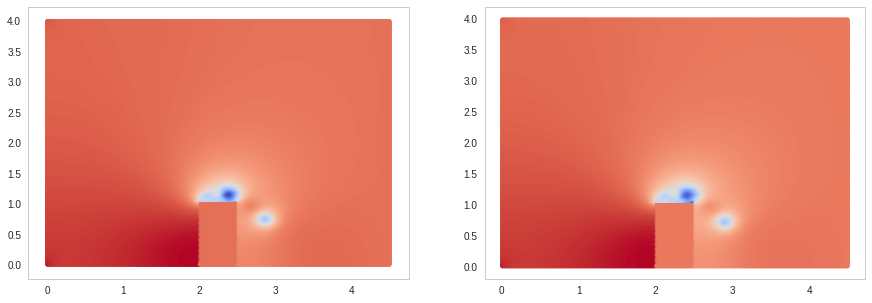

In [111]:
#Visualization of the results 
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.scatter(data.ccx,data.ccy,c=clf.predict(datainput),s=20.,cmap='coolwarm')
plt.scatter(data.ccx,data.ccy,c=data1.pin,s=20.,cmap='coolwarm')
plt.subplot(122)
plt.scatter(data.ccx,data.ccy,c=data3.pin,s=20.,cmap='coolwarm')

In [113]:
# Testing the model in another time-step

datainput = data2.drop(['ccx','ccy'],axis=1).copy()
dataoutput = data3['pin'].copy()
dataoutput = (dataoutput - datainput.pin.min())/(datainput.pin.max()-datainput.pin.min())
print(r2_score(dataoutput,clf.predict(datainput)))
print(r2_score(data3.pin,datainput.pin))

0.983448672048
0.994125330234
